In [1]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB7

2024-07-26 16:21:30.728732: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 16:21:30.728869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 16:21:30.857744: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# إعداد البيانات
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

def create_dataframe(data_dir):
    filepaths = []
    labels = []
    for fold in os.listdir(data_dir):
        foldpath = os.path.join(data_dir, fold)
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_df = create_dataframe(train_data_dir)
test_df = create_dataframe(test_data_dir)

valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)

batch_size = 16 # Reduced batch size
img_size = (224, 224)
img_shape = (img_size[0], img_size[1], 3)

tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)



Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [18]:
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [3]:
# Load the EfficientNetB7 model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=img_shape)


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.1)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy >= 0.98 and abs(accuracy - val_accuracy) < 0.02:
            self.model.stop_training = True

checkpoint_callback = ModelCheckpoint(
    'best_model.h5.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [9]:

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    callbacks=early_stopping_callback
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1722011450.180174     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722011450.558211     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7687 - loss: 19.9358

W0000 00:00:1722011605.384252     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/357 ━━━━━━━━━━━━━━━━━━━━ 644s 488ms/step - accuracy: 0.7690 - loss: 19.8990 - val_accuracy: 0.5344 - val_loss: 1.3650
Epoch 2/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 390ms/step - accuracy: 0.9335 - loss: 0.3230 - val_accuracy: 0.8687 - val_loss: 0.4738
Epoch 3/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 390ms/step - accuracy: 0.9530 - loss: 0.2333 - val_accuracy: 0.9863 - val_loss: 0.1513
Epoch 4/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 391ms/step - accuracy: 0.9686 - loss: 0.1789 - val_accuracy: 0.9863 - val_loss: 0.1186
Epoch 5/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 389ms/step - accuracy: 0.9718 - loss: 0.1691 - val_accuracy: 0.9817 - val_loss: 0.1389
Epoch 6/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 390ms/step - accuracy: 0.9798 - loss: 0.1337 - val_accuracy: 0.9908 - val_loss: 0.1118
Epoch 7/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 389ms/step - accuracy: 0.9824 - loss: 0.1314 - val_accuracy: 0.9893 - val_loss: 0.1038
Epoch 8/20
357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 387ms/step - accuracy: 0.9825 - loss: 0.1

In [14]:
# Save the final model
model.save('/kaggle/working/final_model.h5')


In [15]:
# List files in the current working directory to verify the model is saved
print(os.listdir('/kaggle/working'))

['.virtual_documents', 'final_model.h5']


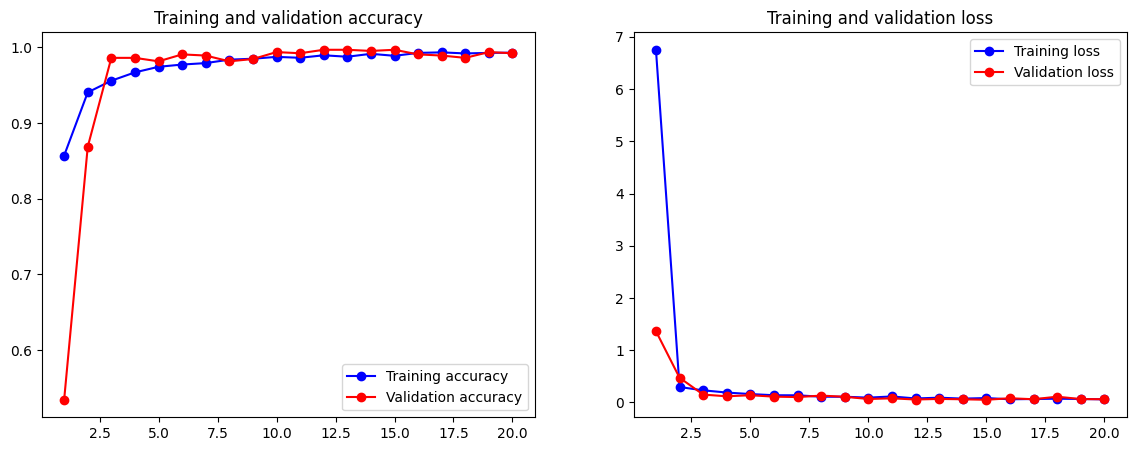

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9965 - loss: 0.0692
Test Loss: 0.06615912914276123
Test Accuracy: 0.9969512224197388


In [13]:
# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


In [19]:
class_labels = list(train_gen.class_indices.keys())
print("Class labels:", class_labels)


Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [22]:
def predict_image(image_path, model, img_size, class_labels):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    return predicted_class_label

# Example usage
image_path = '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0013.jpg'  # Replace with the path to your image
predicted_class = predict_image(image_path, model, img_size, class_labels)
print(f'Predicted class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class: pituitary
